# Beispiel CNN zum Erkennen von Bildern mit Hunden oder Katzen.

Dafür benötigen wir zunächst den Datensatz von Kaggle: https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [3]:
import shutil
import os 
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2, numpy as np
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms,models,datasets
from PIL import Image
from torch import optim
from random import shuffle, seed
from torchsummary import summary
from tqdm.notebook import tqdm

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
current_dir = Path.cwd()
target_dir = current_dir / "cat-and-dog"
print("Working with", device)

if not os.path.exists(target_dir):
    path = kagglehub.dataset_download("tongpython/cat-and-dog")
    print("Downloaded dataset")
    # copy folder from cache to current directory
    shutil.move(path, target_dir, dirs_exist_ok=True)

    print("Dataset moved to:", target_dir)
else:
    print("Dataset exists in", target_dir)

Working with cuda
Dataset exists in c:\Users\jadta\Documents\Arbeit\Werkstudent Lebert Software Engineering\Beispiel Code\PyTorch practice\cat-and-dog


In [3]:
train_data_dir = target_dir / "training_set/training_set"
test_data_dir = target_dir / "test_set/test_set"

In [4]:
seed(10)

class CatsDogsData(Dataset):
    def __init__(self, folder):
        # convert path to string
        if isinstance(folder, Path):
            folder = folder.as_posix()

        # extract all images with certain pattern
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats + dogs

        # randomize file paths and create target variables: cat=0, dog=1
        shuffle(self.fpaths)
        self.targets = [fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths]
    
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        file = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(file)[:,:,::-1]) # switch from cv2's BGR to RGB
        im = cv2.resize(im, (224,224)) # resize images to same resolution
        im_tensor = torch.tensor(im/255).permute(2,0,1).float().to(device) # normalize data and put channels in first dimension
        target_tensor = torch.tensor([target]).float().to(device)

        return im_tensor, target_tensor

tensor([1.], device='cuda:0')


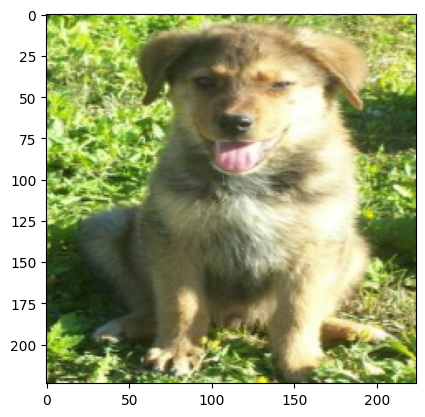

In [5]:
data = CatsDogsData(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu()) # imshow expects channels to be last
print(label)

In [4]:
class CatsDogsCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.arch = nn.Sequential(
            self.conv_layer(3, 64, 3),
            self.conv_layer(64, 512, 3),
            self.conv_layer(512, 512, 3),
            self.conv_layer(512, 512, 3),
            self.conv_layer(512, 512, 3),
            self.conv_layer(512, 512, 3),
            nn.Flatten(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        ).to(device)

    def conv_layer(self, ni, no, kernel_size, stride=1):
        return nn.Sequential(
            nn.Conv2d(ni, no, kernel_size, stride),
            nn.ReLU(),
            nn.BatchNorm2d(no),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.arch(x)
        return x

def get_model():
    model = CatsDogsCNN()
    loss_fn = nn.BCELoss() # predicting 2 classes
    opt = optim.Adam(model.parameters(), lr=0.001)
    return model, loss_fn, opt

In [7]:
def get_data():
    # dropping last batch as it could have a different size
    train = CatsDogsData(train_data_dir)
    train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    
    val = CatsDogsData(test_data_dir)
    val_loader = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)

    return train_loader, val_loader

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
train_loader, val_loader = get_data()
print("Dataset is divided into", len(train_loader), "batches.")
model, loss_fn, opt = get_model()
summary(model, torch.zeros(1,3,244,244))

Dataset is divided into 250 batches.
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 64, 121, 121]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 242, 242]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 242, 242]        --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 242, 242]        128
|    |    └─MaxPool2d: 3-4               [-1, 64, 121, 121]        --
|    └─Sequential: 2-2                   [-1, 512, 59, 59]         --
|    |    └─Conv2d: 3-5                  [-1, 512, 119, 119]       295,424
|    |    └─ReLU: 3-6                    [-1, 512, 119, 119]       --
|    |    └─BatchNorm2d: 3-7             [-1, 512, 119, 119]       1,024
|    |    └─MaxPool2d: 3-8               [-1, 512, 59, 59]         --
|    └─Sequential: 2-3                   [-1, 512, 28, 28]         --
|    |    └─Conv2d: 3-9             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 64, 121, 121]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 242, 242]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 242, 242]        --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 242, 242]        128
|    |    └─MaxPool2d: 3-4               [-1, 64, 121, 121]        --
|    └─Sequential: 2-2                   [-1, 512, 59, 59]         --
|    |    └─Conv2d: 3-5                  [-1, 512, 119, 119]       295,424
|    |    └─ReLU: 3-6                    [-1, 512, 119, 119]       --
|    |    └─BatchNorm2d: 3-7             [-1, 512, 119, 119]       1,024
|    |    └─MaxPool2d: 3-8               [-1, 512, 59, 59]         --
|    └─Sequential: 2-3                   [-1, 512, 28, 28]         --
|    |    └─Conv2d: 3-9                  [-1, 512, 57, 57]         2,359,

In [9]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

epochs = 5
for epoch in range(epochs):
    print(10*"-", "Epoch", epoch+1, 10*"-")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in tqdm(enumerate(train_loader), desc="Training"):
        x, y = batch
        batch_loss = train_batch(x, y, model, opt, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in tqdm(enumerate(train_loader), desc="Calculating train acc"):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in tqdm(enumerate(val_loader), desc="Calculating val acc"):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_accuracy)
    val_acc.append(val_epoch_accuracy)

---------- Epoch 1 ----------


Training: 0it [00:00, ?it/s]

Calculating train acc: 0it [00:00, ?it/s]

Calculating val acc: 0it [00:00, ?it/s]

---------- Epoch 2 ----------


Training: 0it [00:00, ?it/s]

Calculating train acc: 0it [00:00, ?it/s]

Calculating val acc: 0it [00:00, ?it/s]

---------- Epoch 3 ----------


Training: 0it [00:00, ?it/s]

Calculating train acc: 0it [00:00, ?it/s]

Calculating val acc: 0it [00:00, ?it/s]

---------- Epoch 4 ----------


Training: 0it [00:00, ?it/s]

Calculating train acc: 0it [00:00, ?it/s]

Calculating val acc: 0it [00:00, ?it/s]

---------- Epoch 5 ----------


Training: 0it [00:00, ?it/s]

Calculating train acc: 0it [00:00, ?it/s]

Calculating val acc: 0it [00:00, ?it/s]

C:\Users\jadta\AppData\Local\Temp\ipykernel_2920\1952966333.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


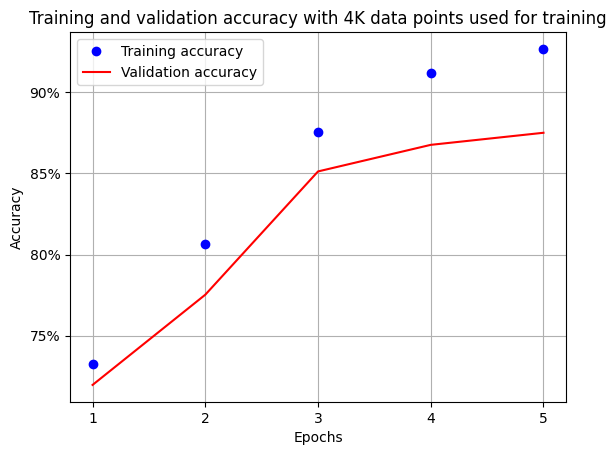

In [10]:
torch.save(model.state_dict(), "models/cats_dogs_model2.pth")

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_acc, 'bo', 
         label='Training accuracy')
plt.plot(epochs, val_acc, 'r', 
         label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Test model on unseen data

In [5]:
def pred_image(filename, model):
    model.eval() 

    example_img = current_dir / f"{filename}.jpg"
    im = cv2.imread(example_img.as_posix())[:,:,::-1]
    im = cv2.resize(im, (224,224))
    im_tensor = torch.tensor(im/255).permute(2,0,1).float()

    plt.imshow(im)
    plt.axis("off")

    im_tensor = im_tensor.unsqueeze(0).to(device)
    pred = model(im_tensor)
    pred_class = "dog" if pred >= 0.5 else "cat"
    print(f"The image contains a {pred_class}.\n{round(pred.item(), 4)}")

The image contains a cat.
0.022


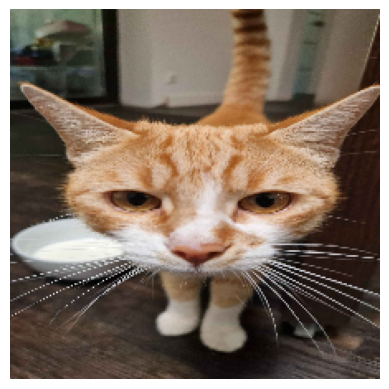

In [10]:
model = CatsDogsCNN()
model.load_state_dict(torch.load("models/cats_dogs_model.pth"))
pred_image("test_images/example_cat", model)

## Trying to extract a CAM

In [94]:
def get_img(filename):
    example_img = current_dir / f"{filename}.jpg"
    im = cv2.imread(example_img.as_posix())[:,:,::-1]
    im = cv2.resize(im, (224,224))
    im_tensor = torch.tensor(im/255).permute(2,0,1).float()
    im_tensor = im_tensor.unsqueeze(0).to(device)
    return im, im_tensor

def im2gradCAM(x, model):
    im2fmap = nn.Sequential(*(list(model.arch[:5].children())+list(model.arch[5][:1].children())))

    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    pred = logits
    model.zero_grad()
    
    # compute gradients with respect to model's most confident logit
    logits[0,0].backward(retain_graph=True)

    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.arch[-6][0].weight.grad.data.mean((1,2,3))

    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]

    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, "dog" if pred >= 0.5 else "cat"

SZ = 224
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

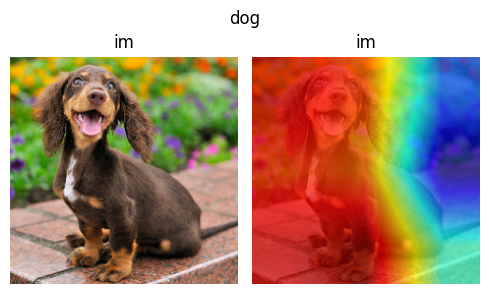

In [98]:
from torch_snippets import *
model = CatsDogsCNN()
model.load_state_dict(torch.load("models/cats_dogs_model.pth"))

im, im_tensor = get_img("dachshund")

heatmap, pred = im2gradCAM(im_tensor, model)
heatmap = upsampleHeatmap(heatmap, im)
subplots([im, heatmap], nc=2, figsize=(5,3), suptitle=pred)

## Object detection